## Target Maximization

This section covers budget optimization by maximizing revenues with the insights from a fitted MMM and a user supplied LTV analysis (in channel level).

In revenue maximization, the objective function is define as

\begin{align*}
R & = \sum^K_k (\text{LTV}_k - \text{Cost per Acqusition}_k) \times \text{Attribution}_k \\
  & = \sum^K_k (\text{LTV}_k - \frac{\text{Spend}_k}{\text{Attribution}_k})  \times \text{Attribution}_k \\
  & = \sum^K_k (\text{LTV}_k \times \text{Attribution}_k  - \text{Spend}_k)
\end{align*}

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle

from karpiu.planning import RevenueMaximizer
from karpiu.planning.calculator import calculate_marginal_cost, generate_cost_report
from karpiu.explainability import Attributor

pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 50)

In [2]:
%load_ext autoreload
%autoreload 2

Bring back the fitted model from previous `Quickstart` section.

In [3]:
with open("./resource/model.pkl", "rb") as f:
    mmm = pickle.load(f)

In [4]:
budget_start = pd.to_datetime("2021-01-01")
budget_end = pd.to_datetime("2021-01-31")
optim_channels = mmm.get_spend_cols()
# to be safe in beta version, use sorted list of channels
optim_channels.sort()

# spend_scaler a fixed constant to reduce over-float of spend
# not that they need to be consistent with the subsequent calculation of
# post optimization metrics
spend_scaler = 1e3

In [5]:
optim_channels

['promo', 'radio', 'search', 'social', 'tv']

Given the customers life-time value (LTV), one can run the revenue maximization.

In [6]:
# ltv_arr = [15.5, 25.5, 30.6, 25.8, 20.8]
ltv_arr = [10.5, 18.5, 32.6, 20.8, 19.8]

In [7]:
df = mmm.get_raw_df()
init_spend_matrix = df.loc[
    (df["date"] >= budget_start) & (df["date"] <= budget_end), optim_channels
].values
init_spend_matrix.shape

(31, 5)

### Optimization Default Setting

In [131]:
maximizer = RevenueMaximizer(
    ltv_arr=ltv_arr,
    model=mmm,
    optim_channel=optim_channels,
    budget_start=budget_start,
    budget_end=budget_end,
    spend_scaler=1.,
    response_scaler=1.,
)
optim_spend_df = maximizer.optimize(maxiter=1000, eps=1e-3)

Iteration limit reached    (Exit mode 9)
            Current function value: 841532.1448054824
            Iterations: 1000
            Function evaluations: 156000
            Gradient evaluations: 1000


In [138]:
optim_spend_matrix = maximizer.get_current_state()
init_spend_matrix = maximizer.get_init_state()

In [139]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(optim_spend_matrix)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 236676
Total Budget: 490508


#### Budget Allocation

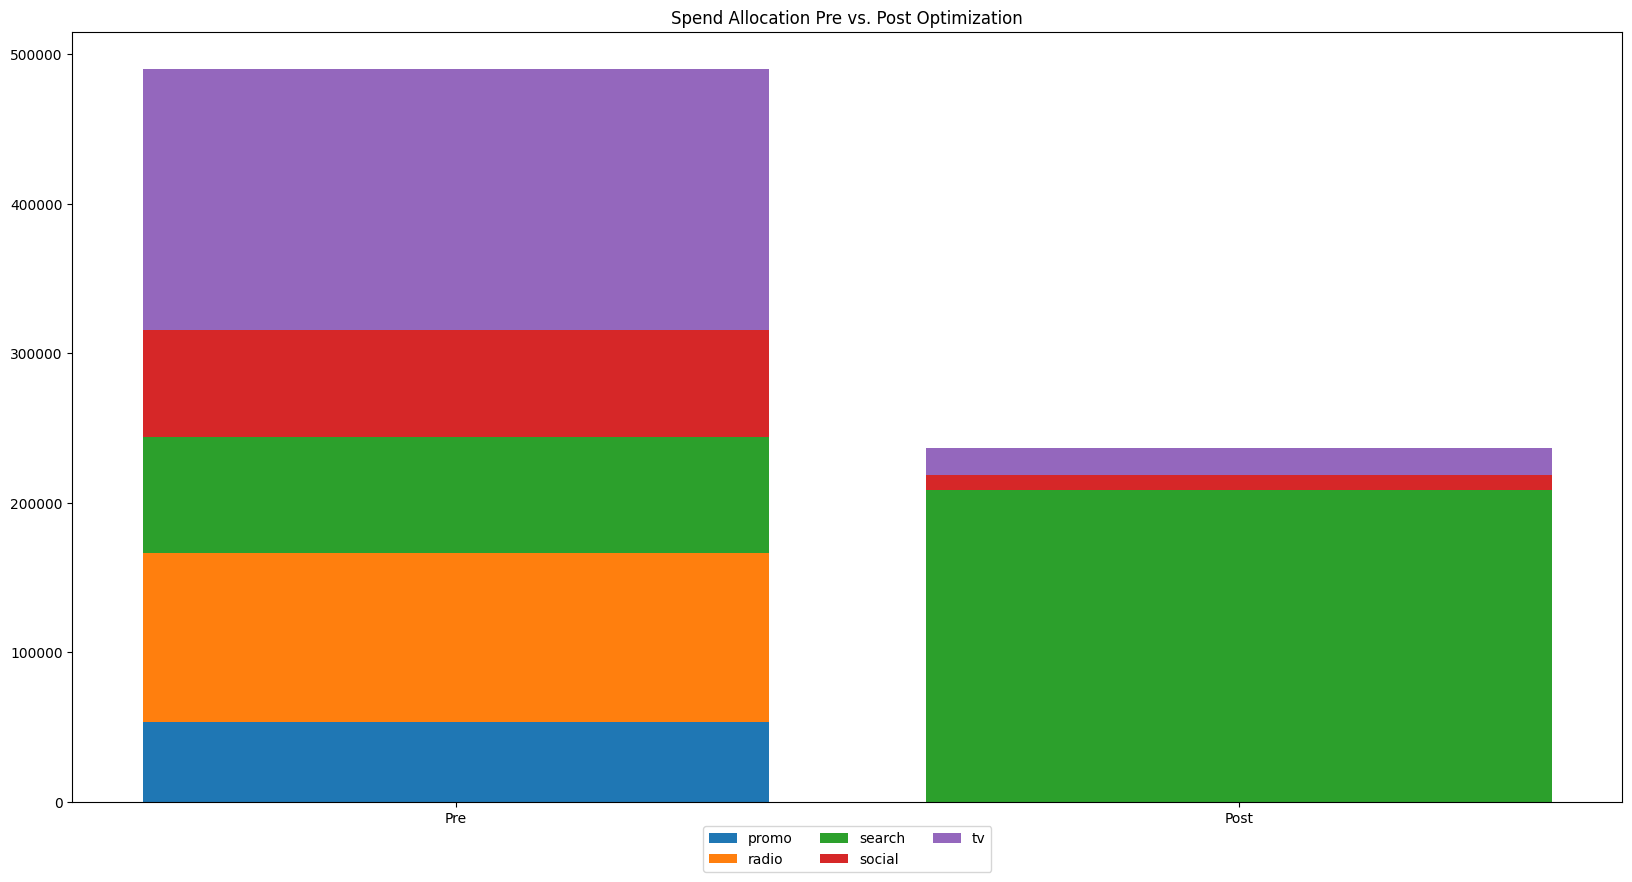

In [140]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=["Pre", "Post"], height=plot_data[:, idx], bottom=bottom, label=label)
    bottom += plot_data[:, idx]
ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=math.ceil(len(optim_channels) / 2),
);

#### Average and Marginal Cost Change

In [141]:
df = mmm.get_raw_df()

In [142]:
cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)
cost_report["ltv"] = ltv_arr
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend,ltv
promo,29.02453,NaN,32.39022,17.87807,53.30000,0.00000,10.50000
radio,24.91365,10.38619,27.95382,14.90602,112.97900,0.00000,18.50000
search,13.34968,20.53751,14.70896,28.14817,78.03300,208.88410,32.60000
social,20.34078,11.16646,22.42905,15.50401,71.64400,10.09164,20.80000
tv,22.68934,10.97632,24.86855,15.98344,174.55200,17.70047,19.80000


In [143]:
pre_ac = cost_report["pre-opt-avg-cost"].values
pre_mc = cost_report["pre-opt-marginal-cost"].values
post_ac = cost_report["post-opt-avg-cost"].values
post_mc = cost_report["post-opt-marginal-cost"].values
assert np.all(pre_mc >= pre_ac)
assert np.all(post_mc >= post_ac)

AssertionError: 

In [144]:
from karpiu.explainability import Attributor

In [145]:
attr_obj = Attributor(
    mmm,
    attr_regressors=optim_channels,
    start=budget_start,
    end=budget_end,
    df=optim_spend_df
)
res = attr_obj.make_attribution()

_, spend_attr_df, spend_df, _ = res
base_spend_attr_matrix = np.sum(spend_attr_df[optim_channels].values, 0)
base_spend_matrix = np.sum(spend_df[optim_channels].values, 0)
base_rev =  base_spend_attr_matrix * (ltv_arr)
base_net_arr = base_rev - base_spend_matrix
base_net_arr.sum()

145621.2574492427

In [146]:
base_rev

array([     0.        ,      0.0000001 , 331569.98859257,  18797.89827212,
        31929.57266643])

In [147]:
base_spend_matrix

array([     0.        ,      0.00000006, 208884.09550293,  10091.63801613,
        17700.46856287])

In [148]:
base_net_arr

array([     0.        ,      0.00000004, 122685.89308965,   8706.26025599,
        14229.10410356])

In [149]:
from copy import deepcopy

In [150]:
input_mask = (
    (optim_spend_df["date"] >= budget_start) &
    (optim_spend_df["date"] <= budget_end)
)

In [151]:
delta=10.

In [152]:
new_revs = np.empty(len(optim_channels))
for idx, ch in enumerate(optim_channels):
    new_spend_df = deepcopy(optim_spend_df)
    delta_matrix = np.zeros_like(new_spend_df.loc[input_mask, optim_channels])
    delta_matrix[:, idx] += delta
    new_spend_df.loc[input_mask, optim_channels] += delta_matrix
    attr_obj = Attributor(
        mmm,
        attr_regressors=optim_channels,
        start=budget_start,
        end=budget_end,
        df=new_spend_df
    )
    res = attr_obj.make_attribution()
    _, spend_attr_df, spend_df, _ = res
    new_spend_attr_matrix = np.sum(spend_attr_df[optim_channels].values, 0)
    new_spend_matrix = np.sum(spend_df[optim_channels].values, 0)
    new_rev = new_spend_attr_matrix * (ltv_arr) 
    new_net_arr = new_rev - new_spend_matrix
    new_revs[idx] = new_net_arr.sum()

In [153]:
new_net_arr

array([     0.        ,      0.00000004, 122685.026084  ,   8706.19866672,
        14358.90719793])

In [154]:
new_spend_matrix

array([     0.        ,      0.00000006, 208884.09550293,  10091.63801613,
        18010.46856287])

In [155]:
new_rev

array([     0.        ,      0.0000001 , 331569.12158692,  18797.83668284,
        32369.37576081])

In [156]:
new_revs - base_net_arr.sum()

array([-113.79810411,  168.0681505 , -109.44886549,  145.21675012,
        128.87449945])

In [14]:
budget_delta = (
    cost_report["post-opt-spend"].values - cost_report["pre-opt-spend"].values
)
ltv_min_pre_opt_mc = (
    cost_report["ltv"].values - cost_report["pre-opt-marginal-cost"].values
)

In [15]:
budget_delta

array([-37.73397069, -73.81245679, -13.88725334, -34.10122253,
       -94.48728557])

In [16]:
ltv_min_pre_opt_mc

array([-21.88973169,  -9.45359682,  17.89114934,  -1.62869602,
        -5.06820186])

To validate the result, one should see the patterns:
- when `pre-opt-marginal-cost` is lower than `ltv`, a increase of spend is expected and hence resulting a higher `post-opt-marginal-cost`
- on the contrary, when `pre-opt-marginal-cost` is higher than `ltv`, a decrease of spend is expected and hence resulting a lower `post-opt-marginal-cost`
- if the final `ltv` is still lower than the `post-opt-marginal-cost`, one should always expect zero spend suggested for the channel

### Run optimization with an additional constraint

`.generate_individual_channel_constraints()` is designed to help to generate convenient invidiaul budget constraints with respect to the total budget. For example, by specifying `delta=0.2`, one should expect the total resulting spend of the channel will be within $\pm 20 \%$ of the original budget.

In [17]:
maximizer2 = RevenueMaximizer(
    ltv_arr=ltv_arr,
    model=mmm,
    optim_channel=optim_channels,
    budget_start=budget_start,
    budget_end=budget_end,
    spend_scaler=10.0,
)

ind_constraints = maximizer2.generate_individual_channel_constraints(delta=0.2)
maximizer2.add_constraints(ind_constraints)
optim_spend_df2 = maximizer2.optimize(maxiter=1000, eps=1e-3)

new_cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df2,
)
new_cost_report["ltv"] = ltv_arr
new_cost_report

Iteration limit reached    (Exit mode 9)
            Current function value: -50870.73749454496
            Iterations: 1000
            Function evaluations: 155688
            Gradient evaluations: 998


,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend,ltv
promo,29.02453,25.60422,32.38973,30.16676,53.30000,42.64000,10.50000
radio,24.91365,22.76469,27.95360,25.67584,112.97900,90.38320,18.50000
search,13.34968,14.91123,14.70885,16.15230,78.03300,93.63960,32.60000
social,20.34078,18.40478,22.42870,21.06470,71.64400,57.31520,20.80000
tv,22.68934,20.58323,24.86820,22.87690,174.55200,139.64160,19.80000


In [18]:
new_cost_report["post-opt-spend"].values.sum()

423.6196000000001

In [19]:
new_cost_report["pre-opt-spend"].values.sum()

490.50800000000004

In [20]:
budget_delta = (
    new_cost_report["post-opt-spend"].values - new_cost_report["pre-opt-spend"].values
)
ltv_min_pre_opt_mc = (
    new_cost_report["ltv"].values - new_cost_report["pre-opt-marginal-cost"].values
)

In [21]:
budget_delta

array([-10.66  , -22.5958,  15.6066, -14.3288, -34.9104])

In [22]:
ltv_min_pre_opt_mc

array([-21.88973169,  -9.45359682,  17.89114934,  -1.62869602,
        -5.06820186])

In [23]:
# Test extra batches dimension for adstock process

In [24]:
# teset create multiple scenarios with (full spend, one-off_1, one-off_2, ...) for the first (batch) dim
spend_matrix = init_spend_matrix
print(spend_matrix.shape)
zero_paddings = np.zeros((maximizer2.n_max_adstock, maximizer2.n_optim_channels))
spend_matrix = np.concatenate([zero_paddings, spend_matrix, zero_paddings], 0)
print(spend_matrix.shape)

# first row always ones
# then rotate the ones on different elements on the last elements
design_broadcast_matrix = np.concatenate(
    [
        np.ones((1, 1, 5)),
        np.expand_dims(np.eye(5), -2),
    ],
    axis=0,
)
print(design_broadcast_matrix.shape)

# duplicate 1 + 5 scanerios
full_sim_sp_matrix = np.tile(np.expand_dims(spend_matrix, 0), reps=(6, 1, 1))
full_sim_sp_matrix = full_sim_sp_matrix * design_broadcast_matrix
print(full_scanerio_spend_matrix.shape)

print(maximizer2.bkg_spend_matrix.shape)
full_sim_sp_matrix += maximizer2.bkg_spend_matrix
full_sim_tran_sp_matrix = adstock_process(
    full_sim_sp_matrix,
    maximizer.optim_adstock_matrix,
)

(31, 5)
(85, 5)
(6, 1, 5)


NameError: name 'full_scanerio_spend_matrix' is not defined

In [ ]:
full_tran_sp_matrix = full_sim_tran_sp_matrix[0]
one_off_sp_matrix = full_sim_tran_sp_matrix[1:, ...]

In [ ]:
maximizer.optim_sat_array.shape

In [ ]:
full_comp = np.sum(
    maximizer.optim_coef_matrix
    * np.log1p(full_tran_sp_matrix / maximizer.optim_sat_array),
    -1,
)
full_comp.shape

In [ ]:
one_off_comp = np.sum(
    maximizer.optim_coef_matrix
    * np.log1p(one_off_sp_matrix / maximizer.optim_sat_array),
    -1,
)
one_off_comp.shape

In [ ]:
maximizer.base_comp.shape

In [ ]:
attr_matrix = np.exp(maximizer.base_comp) * (-np.exp(one_off_comp) + np.exp(full_comp))

In [ ]:
attr_matrix.shape

In [ ]:
# (n_optim_channels, )
revenue = ltv_arr * np.sum(attr_matrix, -1)

In [ ]:
# (n_optim_channels, )
cost = np.sum(spend_matrix, 0)
net_profit = np.sum(revenue - cost)
loss = -1 * net_profit / maximizer.response_scaler

In [ ]:
loss